# Numerické řešení Stokesova problému pomocí MKO

In [1]:
using PyPlot;

In [2]:
include("mesh.jl");
include("fields.jl");
include("operators.jl");

## Definice sítě, počátečních a okrajových podmínek

In [3]:
n = 25
m = cartesian_mesh(n,n);

In [4]:
p = ScalarField(m);
for name ∈ ["left", "right", "bottom", "top"]
    set_neumann_patch!(p, name, 0.0)
end

In [5]:
u = ScalarField(m)
set_dirichlet_patch!(u, "left", 0.0);
set_dirichlet_patch!(u, "right", 0.0);
set_dirichlet_patch!(u, "bottom", 0.0);
set_dirichlet_patch!(u, "top", 1.0);

v = ScalarField(m)
set_dirichlet_patch!(v, "left", 0.0);
set_dirichlet_patch!(v, "right", 0.0);
set_dirichlet_patch!(v, "bottom", 0.0);
set_dirichlet_patch!(v, "top", 0.0);

### Sdružený algoritmus

Soustava rovnic pro řešení Stokesova problému je
$$
    \begin{bmatrix}
    L & 0 & G_x \\
    0 & L & G_y \\
    D_x & D_y & 0
    \end{bmatrix}
    \begin{bmatrix} u \\ v \\ p \end{bmatrix}
    =
    \begin{bmatrix} b_u \\ b_v \\ b_0 \end{bmatrix}.
$$
kde $L$ je matice vzniklá aproximací $-\Delta$, $G_x$ je aproximace $\partial_x$ a $G_y$ je aproximace $\partial_y$. Podobně i $D_x$ a $D_y$.

In [6]:
eq1 = -Δ(1.0e-4, u);
eq2 = -Δ(1.0e-4, v);
eq3 = ∂x(p);
eq4 = ∂y(p);
eq5 = ∂x(u);
eq6 = ∂y(v);

In [7]:
L  = eq1.A;
Gx = eq3.A;
Gy = eq4.A;
Dx = eq5.A;
Dy = eq6.A;
O  = zeros(L);

M = [L  O  Gx;
     O  L  Gy;
     Dx Dy O];

bu = -eq1.b - eq3.b;
bv = -eq2.b - eq4.b;
b0 = -eq5.b - eq6.b;
b = [bu; bv; b0];

Matice $M$ je ale singulární!

In [8]:
#lze to overit, ale trva to dlouho
cond(Array(M))

1.9584386825324426e17

Přidám proto k soustavě 1 rovnici p[end]=0.

In [9]:
M[end,end] = n*n;
cond(Array(M))

120001.79818020208

In [10]:
sol = M \ b;

In [11]:
uu = reshape(sol[1:n*n], (n,n));
vv = reshape(sol[n*n+1:2*n*n], (n,n));
pp = reshape(sol[2*n*n+1:end], (n,n));

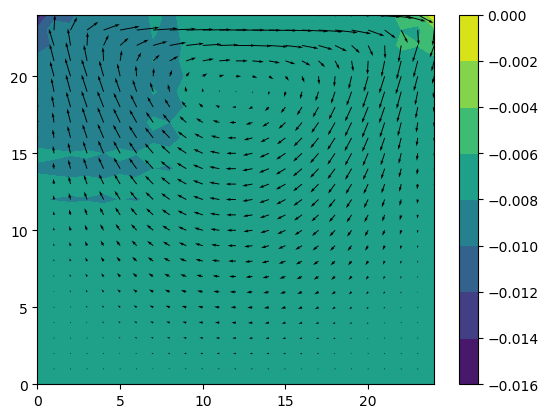

In [12]:
contourf(pp'); colorbar();
quiver(uu',vv');

## Algoritmus SIMPLE pro Stokesuv problem

Na jednotkovém čtevrci [0,1]x[0,1] řešme soustavu rovnic
\begin{align*}
- \Delta U &= - \nabla p, \\
\nabla U &= 0.
\end{align*}

s okrajovými podmínkami
$$
    U(x,y) = \left\{
    \begin{array}{ll}
        [0,0] & \text{pro } x \in [0,1] \land y=1,\\
        [0,0] & \text{pro } x=0 \lor x=1 \lor y=0.
    \end{array}
    \right.
$$
a
$$
    \frac{\partial p}{\partial n} = 0 \,\text{pro } x=0 \lor x=1 \lor y=0 \lor y=1.
$$


Diskretizace:
$$
    a_C U_C = \sum_{f} a_F U_F + Q_C - \nabla p_C = H(U)_C - \nabla p_C,
$$

a tedy

$$
    U_C = \frac{1}{a_C} H(U)_C - \frac{1}{a_C} \nabla p_C.
$$

Definujme
$$
    \hat{U}_C = \frac{1}{a_C} H(U)_C.
$$

Rovnice kontinuity

$$
    0 = \nabla U_C = \nabla(\hat{U}_C - \frac{1}{a_C} \nabla p_C)
$$

a tedy

$$
    \nabla(\frac{1}{a_C} \nabla p_C) = \nabla(\hat{U}_C).
$$

Výsledná rovnice pro tlak však stále obsahuje neznámé rychlosti. Algoritmus SIMPLE řeší danou soustavu rovnic iteračně s tím, že se řeší zvlášť rovnice pro rychlosti a zvlášť rovnice pro tlak.

### Algortimus SIMPLE ve variantě s korekcemi tlaku a rychlosti

V této variantě algoritmu SIMPLE vycházíme ze stavu $U^n$ a $p^n$ a pokusíme se vypočítat novou aproximaci $U^{n+1}$ a $p^{n+1}$.

1. Řešíme rovnici pro rychlost s tlakem $p^n$, tj. $U^*_C = \frac{1}{a_c} H(U^*)_C - \frac{1}{a_C} \nabla p_C^n$.
Tato nová rychlost $U^*$ však nesplňuje rovnici kontinuity a navíc byla vypočtena pomocí $p^n$ a nikoliv zatím neznámého $p^{n+1}$.
2. Označme $U' = U^{n+1} - U^*$ a $p'=p^{n+1}-p^n$ a odečtěme od rovnice pro rychlost v iteraci $n+1$ rovnici pro $U^*$, tedy (za předpokladu linearity $H$)
\begin{array}{rll}
U^{n+1}_C &= \frac{1}{a_c} H(U^{n+1})_C - \frac{1}{a_C} \nabla p_C^{n+1}, & \\
U^*_C &= \frac{1}{a_C} H(U^*)_C - \frac{1}{a_C} \nabla p_C^n, & \cdot(-1) \\
\hline \\
U'_C &= \frac{1}{a_C} H(U')_C - \frac{1}{a_C} \nabla p'_C. & 
\end{array}
3. Rovnice pro $U'$ však opět svazuje $U'$ a $p'$. Proto v rovnici **zanedbáme** člen s $H(U')$ a dostáváme vztah pro korekci rychlosti
\begin{equation}
    U'_C \approx - \frac{1}{a_C}\nabla p_C.
\end{equation}
4. Z rovnice kontinuity pro $U^{n+1}$ dostáváme $0 = \nabla\cdot U^{n+1} = \nabla\cdot U^* + \nabla\cdot U'$ a tedy
\begin{equation}
    \nabla(\frac{1}{a_C}\nabla p') = \nabla\cdot U^*.
\end{equation}
Tuto rovnici rovnici doplníme vhodnými okrajovými podmínkami pro $p'$ (tj. tak, aby $p^{n+1} = p^n + p'$ splňovalo zadané podmínky pro tlak) a určíme $p'$ a $p^{n+1}$.
5. Z rovnice pro korekci rychlosti určíme $U' = - \frac{1}{a_C}\nabla p'_C$ a $U^{n+1}=u^n + U'$.
6. Celý postup opakujeme dokude není $||U'||$ a $||p'||$ dostatečně malá.

### Algoritmus SIMPLE ve variantě s tlakem

Tato varianta je velmi podobná předchozímu algoritmu. Narozdíl od něj však nepočítá s korekcemi tlaku ale přímo s tlakem.

1. Řešíme rovnici pro rychlost s tlakem $p^n$, tj. $U^*_C = \frac{1}{a_c} H(U^*)_C - \frac{1}{a_C} \nabla p_C^n$.
2. Označme $\hat U = \frac{1}{a_c} H(U^*)_C$. Potom
\begin{equation}
U^{n+1}_C = \left[\frac{1}{a_c} H(U^{n+1})_C - \hat{U}\right] + \hat{U} - \frac{1}{a_C} \nabla p_C^{n+1}.
\end{equation}
Stejně jako v předchozí variantě **zanedbáme** výraz v hranaté závorce na pravé straně a dostáváme
\begin{equation}
U^{n+1}_C \approx \hat{U} - \frac{1}{a_C} \nabla p_C^{n+1}.
\end{equation}
3. Z rovnice kontinuity pro $U^{n+1}$ dostáváme $0 = \nabla\cdot U^{n+1} = \nabla\cdot \hat{U} - \frac{1}{a_C}\nabla p^{n+1}_C$ a tedy
\begin{equation}
    \nabla(\frac{1}{a_C}\nabla p^{n+1}) = \nabla\cdot \hat{U}.
\end{equation}
4. Z rovnice pro rychlost určíme $U^{n+1} = \hat{U} - \frac{1}{a_C}\nabla p_C$.
5. Celý postup opakujeme dokude není $||U^{n+1}-U^n||$ a $||p^{n+1}-p^n||$ dostatečně malá.

In [13]:
U = VectorField(m)
set_dirichlet_patch!(U, "left", Vec2d(0,0));
set_dirichlet_patch!(U, "right", Vec2d(0,0));
set_dirichlet_patch!(U, "bottom", Vec2d(0,0));
set_dirichlet_patch!(U, "top", Vec2d(1,0));
p.values = zeros(p.values);

In [ ]:
Ueqn = - Δ(1e-4, U);

In [ ]:
solve!(Ueqn + ∇(p));

In [ ]:
#Ac{T}(eq::Equation{T}) = diag(eq.A);
#H{T}(eq::Equation{T}) =  -eq.b .+ Ac(eq) .* eq.x .-  eq.A * eq.x;

In [ ]:
ra = 1 ./ Ac(Ueqn);

In [ ]:
Ubar = VectorField(ra .* H(Ueqn), U.mesh, U.boundaries);

In [ ]:
ra .* H(Ueqn);

In [ ]:
pEqn = Δ(ra, p) - ∇(Ubar);
pEqn.A[1,1] += 1;

In [ ]:
solve!(pEqn)

In [ ]:
pp = reshape(p.values, (n,n))
contourf(pp'); colorbar();

In [ ]:
U ← Ubar - ra .* ∇(p);

In [ ]:
component(f::VectorField, c) = [ v[c] for v in f.values ]

In [ ]:
uu = reshape(component(U,1), (n,n));
vv = reshape(component(U,2), (n,n));
pp = reshape(p.values, (n,n));

In [ ]:
contourf(pp'); colorbar();
quiver(uu',vv');

### Relaxace v algoritmu SIMPLE

Významnou roli v algoritmu SIMPLE hraje řešení soustav rovnic pro $U$ a $p$. Zatímco soustava rovnic pro $p$ vznikne diskretizací Poissonovy rovnice (a je tedy při vhodné diskretizaci symetrická a pozitivně definitní), soustava pro $U$ už symetrická být nemusí (díky konvektivním členům). Navíc v rovnici pro $U'$ zanedbáváme člen $H(U')/a_C$ a cht2li bychom, aby tento člen byl vzhledem k $U'$ malý. Proto je nutné v rovnici pro rychlost použí **relaxaci**.

Mějme soustavu lineárních rovnic $Ax=b$. Označme $x^*$ přesné řešení této soustavy a $x^n$ $n$-tou iteraci níže popsané relaxační metody. Tu získáme tak, že k řešíme místo původní soustavy soustavu vzniklou součtem $A x^{n+1} = b$ s vhodným násobek $Dx^{n+1}=Dx^n$, kde $D=diag(A)$, tedy
\begin{equation}
  A x^{n+1} + \frac{1-\alpha}{\alpha} D x^{n+1} = b + \frac{1-\alpha}{\alpha} D x^n,
\end{equation}
neboli
\begin{equation}
  \left(\frac{D}{\alpha} + (A-D)\right) x^{n+1} = b + \frac{1-\alpha}{\alpha} D x^n.
\end{equation}
Při vhodné volbě $\alpha \in (0,1)$ je matice relaxované soustavy ODD. 

To má význam i pro odhad velikosti $H(U')$. Je-li $U' \approx const.$, pak $H(U')_C/a_C \approx \alpha U'_C$ a tedy lze tento člen v algoritmu SIMPLE zanedbat.

Dalším místem, kde v algoritmu SIMPLE zanedbáváme člen $H(U')$ je vztah pro $U'_C$. Provedeme-li relaxaci rovnice pro rychlost, pak lepší odhad korekce rychlosti bude
$$
    U'_C = \frac{1}{a_C} H(U')_C - \frac{1}{a_C} \nabla p'_C \approx \alpha U'C - \frac{1}{a_C} \nabla p'_C,
$$
tedy pro $\beta = 1 - \alpha$
$$
    U'_C = - \frac{1}{\beta a_C} \nabla p'_C.
$$
Označme $p" = p'_C / \beta$. Potom $U'_C = - \frac{1}{a_C} \nabla p"_C$ a $p"$ najdeme řešením původní rovnice
\begin{equation}
    \nabla(\frac{1}{a_C}\nabla p") = \nabla\cdot U^*.
\end{equation}
Tlak $p^{n+1}$ nakonec upravíme dle vztahu $p^{n+1} = p^n + p' = p^n + \beta p"$.

Ve variantě s korekcí rychlosti tedy
1. Relaxujeme rovnici pro rychlost s relaxačním parameterem $\alpha \in (0,1)$.
2. Postupujeme dle standardního algoritmu SIMPLE s tím, že k tlaku přidáváme pouze $\beta$-násobek korekce.

Vhodné relxační parametry jsou $\alpha + \beta \approx 1$, 4asto $\alpha=0.7$ a $\beta = 0.3$.

In [ ]:
p.values = zeros(n*n)
U.values = zeros(Vec2d,n*n)

α = 0.7
β = 0.3
ν = 1.0e-4

for iter = 0:50
    
    U_old, p_old = copy(U.values), copy(p.values)
    
    Ueqn = -Δ(ν,U)

    relax!(Ueqn, α)
    
    solve!(Ueqn + ∇(p))
    
    ra = 1 ./ Ac(Ueqn);
    
    Ubar = VectorField(ra .* H(Ueqn), U.mesh, U.boundaries);
    
    pEqn = Δ(ra, p) - ∇(Ubar);
    pEqn.A[1,1] -= n*n
    solve!(pEqn)
    
    p ← β*p + (1-β)*p_old
    U ← Ubar - ra .* ∇(p)
    
    if rem(iter,5)==0
        nxny = n*n
        pRez = norm(p_old - p.values) / nxny
        cont = norm(∇(U)) / nxny
        println(iter, "\t", pRez, "\t", cont)
    end
end

In [ ]:
uu = reshape(component(U,1), (n,n));
vv = reshape(component(U,2), (n,n));
pp = reshape(p.values, (n,n));

In [ ]:
contourf(pp'); colorbar();
quiver(uu',vv');

In [ ]:
# Ψ_x = v, Ψ_y = - u

function streamfunction(u, v, Δx=1, Δy=1)
    Ψ1 = zeros(u)

    Ψ1[1,1] = 0.0
    for i=2:size(u,1)
        Ψ1[i,1] = Ψ1[i-1,1] + Δx * (v[i,1]+v[i-1,1])/2
    end
    for j=2:size(u,2)
        Ψ1[:,j] = Ψ1[:,j-1] - Δy * (u[:,j]+u[:,j-1])/2
    end

    Ψ2 = zeros(Ψ1)
    
    Ψ2[1,1] = 0.0
    for j=2:size(u,2)
        Ψ2[1,j] = Ψ2[1,j-1] - Δy * (u[1,j,1]+u[1,j-1])/2
    end
    for i=2:size(u,1)
        Ψ2[i,:] = Ψ2[i-1,:] + Δx * (v[i,:]+v[i-1,:])/2
    end
    
    Ψ = (Ψ1 + Ψ2) / 2
    
    #Ψ[end,end] = (Ψ[end-1,end]+Ψ[end,end-1]) / 2
    return Ψ
end

In [ ]:
Ψ = streamfunction(uu,vv,1./25,1./25);

In [ ]:
pos = linspace(0, maximum(Ψ), 10)
contour(Ψ', pos, colors="black");
neg = linspace(minimum(Ψ), 0, 5)
contourf(pp'); colorbar();
contour(Ψ', neg, colors="red");